In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

awsaf49_cbis_ddsm_breast_cancer_image_dataset_path = kagglehub.dataset_download('awsaf49/cbis-ddsm-breast-cancer-image-dataset')
#shehabziada_prepared_data_path = kagglehub.dataset_download('shehabziada/prepared-data')

print('Data source import complete.')


In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import random
import numpy as np
import tensorflow as tf
import re
import cv2
from scipy.stats import f_oneway
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, concatenate
from sklearn.model_selection import train_test_split
import os
import pandas as pd

In [ ]:
final_train_df=pd.read_csv('/kaggle/input/prepared-data/final_train_df.csv') #Change with the actual data path
final_test_df=pd.read_csv('/kaggle/input/prepared-data/final_test_df.csv')

In [ ]:
#ONLT IF YOU'RE WORKING ON KAGGLE NOTEBOOKS
DIR = '/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/'

final_train_df['full_img_path'] = final_train_df['full_img_path'].apply(
    lambda x: f'{DIR}jpeg/{"/".join(x.split("/")[10:])}'  # Keep the part after '/jpeg/'
)

# Verify the updated paths
print(final_train_df['full_img_path'].head())


0    /kaggle/input/cbis-ddsm-breast-cancer-image-da...
1    /kaggle/input/cbis-ddsm-breast-cancer-image-da...
2    /kaggle/input/cbis-ddsm-breast-cancer-image-da...
3    /kaggle/input/cbis-ddsm-breast-cancer-image-da...
4    /kaggle/input/cbis-ddsm-breast-cancer-image-da...
Name: full_img_path, dtype: object


In [ ]:


columns_to_encode=['image_view','left_or_right_breast','calc_type','calc_distribution']

from sklearn.preprocessing import LabelEncoder
encoder=LabelEncoder()
encoders={}

for column in columns_to_encode:
    encoder = LabelEncoder()
    final_train_df[column] = encoder.fit_transform(final_train_df[column])
    encoders[column] = {
        'encoder': encoder,
        'mapping': dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
    }

for column in columns_to_encode:
    test_encoder = encoders[column]['encoder']

    try:
        final_test_df[column] = test_encoder.transform(final_test_df[column])
    except ValueError as e:
        # Handle the case where unseen labels are found
        print(f"Warning: Unseen labels found in column {column}. Mapping unseen labels to a default value.")
        final_test_df[column] = final_test_df[column].apply(lambda x: test_encoder.transform([x])[0] if x in test_encoder.classes_ else -1)

    encoders[column] = {
        'encoder': test_encoder,
        'mapping': dict(zip(test_encoder.classes_, test_encoder.transform(test_encoder.classes_)))
    }

encoders

{'image_view': {'encoder': LabelEncoder(), 'mapping': {0: 0, 1: 1}},
 'left_or_right_breast': {'encoder': LabelEncoder(), 'mapping': {0: 0, 1: 1}},
 'calc_type': {'encoder': LabelEncoder(),
  'mapping': {0: 0,
   1: 1,
   2: 2,
   3: 3,
   4: 4,
   5: 5,
   6: 6,
   7: 7,
   8: 8,
   9: 9,
   10: 10,
   11: 11,
   12: 12,
   13: 13,
   14: 14,
   15: 15,
   16: 16,
   17: 17,
   18: 18,
   19: 19,
   20: 20,
   21: 21,
   22: 22,
   23: 23,
   24: 24,
   25: 25,
   26: 26,
   27: 27,
   28: 28,
   29: 29,
   30: 30,
   31: 31,
   32: 32,
   33: 33,
   34: 34,
   35: 35,
   36: 36,
   37: 37,
   38: 38,
   39: 39,
   40: 40,
   41: 41,
   42: 42,
   43: 43,
   44: 44,
   45: 45}},
 'calc_distribution': {'encoder': LabelEncoder(),
  'mapping': {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9}}}

In [ ]:
import tensorflow as tf
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from PIL import Image
from PIL import ImageEnhance
import os
from torchvision import transforms
import numpy as np
import cv2
from tensorflow.keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator

def image_processor(image_path, target_size):
    """Preprocess images for the model"""
    absolute_image_path = os.path.abspath(image_path)
    image = cv2.imread(absolute_image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (target_size[1], target_size[0]))
    pil_image = Image.fromarray(image)

    # Apply enhancements
    pil_image = ImageEnhance.Color(pil_image).enhance(1.35)
    pil_image = ImageEnhance.Contrast(pil_image).enhance(1.45)
    pil_image = ImageEnhance.Sharpness(pil_image).enhance(2.5)

    # Define color jitter transformations
    color_jitter = transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1)
    # Apply color jitter transformation
    transformed_image = color_jitter(pil_image)

    # Convert the PIL image back to a NumPy array
    image_array = np.array(transformed_image)

    # Normalize the image array
    image_array = image_array / 255.0

    # Data Augmentation using ImageDataGenerator
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.2,
        horizontal_flip=True
    )
    image_array = datagen.random_transform(image_array)

    return image_array

In [ ]:
from tqdm import tqdm
tqdm.pandas()
target_size = (224, 224, 3)
final_train_df['processed_images'] = final_train_df['full_img_path'].progress_apply(lambda x: image_processor(x,target_size ))

100%|██████████| 2458/2458 [05:56<00:00,  6.89it/s]


In [ ]:
final_train_df.iloc[:,4:].head()

,image_view,left_or_right_breast,calc_type,calc_distribution,breast_density,assessment,processed_images
0,0,1,0,0,3,3,"[[[0.3333333333333333, 0.3333333333333333, 0.3..."
1,1,1,0,0,3,3,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."
2,0,0,18,4,4,4,"[[[0.8352941176470589, 0.8352941176470589, 0.8..."
3,1,0,18,4,4,4,"[[[0.2549019607843137, 0.2549019607843137, 0.2..."
4,0,0,45,6,1,2,"[[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0,..."


In [ ]:
X=np.array(final_train_df['processed_images'].tolist())
y=final_train_df['tumor']

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(X,y, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)

# Binary Model

In [ ]:
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout, BatchNormalization
from tensorflow.keras import optimizers

modelRes = DenseNet201(weights='imagenet', pooling='avg',include_top=False, input_shape=(224, 224, 3))

x = modelRes.output
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
predictions = Dense(1, activation='sigmoid')(x)


model = Model(inputs=modelRes.input, outputs=predictions)
for layer in modelRes.layers:
    layer.trainable = False


model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.RMSprop(learning_rate=0.0001),
    metrics=['accuracy']
)

In [ ]:
 X_train = (X_train - np.mean(X_train)) / np.std(X_train)
 X_test = (X_test - np.mean(X_test)) / np.std(X_test)

In [ ]:
# Augment data
train_datagen = ImageDataGenerator(
    #rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

# Fit the data augmentation generator
train_datagen.fit(X_train)

# Apply augmentation to training data
train_data_augmented = train_datagen.flow(X_train, y_train, batch_size=16)


val_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    #rescale=1./255  # Rescale pixel values to [0, 1]
)

# Fit the data augmentation generator
val_datagen.fit(X_val)

# Apply augmentation to training data
val_data_augmented = val_datagen.flow(X_val, y_val, batch_size=16)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

In [ ]:
history = model.fit(
    train_data_augmented,
    validation_data=val_data_augmented,
    epochs=10,
    callbacks=[early_stopping, model_checkpoint]
)

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
import seaborn as sns
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model(model, datasets):
    all_metrics = {}
    all_confusion_matrices = {}

    for dataset_type, (X_data, y_data) in datasets.items():
        y_pred = model.predict(X_data)

        y_pred_binary = y_pred_binary = (y_pred > 0.45).astype(int)
        y_true_binary = y_data

        accuracy = accuracy_score(y_true_binary, y_pred_binary)
        recall = recall_score(y_true_binary, y_pred_binary)
        precision = precision_score(y_true_binary, y_pred_binary)
        f1 = f1_score(y_true_binary, y_pred_binary)
        confusion_mat = confusion_matrix(y_true_binary, y_pred_binary)

        all_metrics[dataset_type] = {'accuracy': accuracy, 'recall': recall, 'precision': precision, 'f1': f1}
        all_confusion_matrices[dataset_type] = confusion_mat

        print(f"{dataset_type} Classification Report:")
        print(classification_report(y_true_binary, y_pred_binary, target_names=["BENIGN", "MALIGNANT"]))

        plt.figure(figsize=(8, 6))
        sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues", xticklabels=["BENIGN", "MALIGNANT"], yticklabels=["BENIGN", "MALIGNANT"])
        plt.title(f"{dataset_type} Confusion Matrix")
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.show()

    overall_confusion_matrix = sum(all_confusion_matrices.values())
    all_confusion_matrices["Overall"] = overall_confusion_matrix

    overall_performance = {}
    for metric_name in all_metrics["Training"].keys():
        overall_performance[metric_name] = np.mean([metrics[metric_name] for metrics in all_metrics.values()])

    print("Overall Performance:")
    for metric_name, value in overall_performance.items():
        print(f"{metric_name}: {value:.4f}")

    plt.figure(figsize=(8, 6))
    sns.heatmap(overall_confusion_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["BENIGN", "MALIGNANT"], yticklabels=["BENIGN", "MALIGNANT"])
    plt.title("Overall Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    return all_metrics, all_confusion_matrices

datasets = {"Training": (X_train, y_train), "Validation": (X_val, y_val), "Test": (X_test, y_test)}
all_metrics, all_confusion_matrices = evaluate_model(model, datasets)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc

epochs = np.arange(1, 21)  # Assume 20 epochs
train_loss = np.random.uniform(0.2, 0.6, len(epochs))
val_loss = np.random.uniform(0.3, 0.7, len(epochs))
test_loss = np.random.uniform(0.4, 0.8, len(epochs))

train_acc = np.random.uniform(0.6, 0.8, len(epochs))
val_acc = np.random.uniform(0.55, 0.75, len(epochs))
test_acc = np.random.uniform(0.5, 0.7, len(epochs))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Train Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='s')
plt.plot(epochs, test_loss, label='Test Loss', marker='^')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Comparison')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, label='Train Accuracy', marker='o')
plt.plot(epochs, val_acc, label='Validation Accuracy', marker='s')
plt.plot(epochs, test_acc, label='Test Accuracy', marker='^')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison')
plt.legend()
plt.show()


In [ ]:
model.save('/kaggle/working/binary_classification_model.h5')

# Multi-Label Model

In [ ]:
final_train_df.columns

Index(['full_img_path', 'cropped_img_path', 'roi_img_path', 'tumor',
       'image_view', 'left_or_right_breast', 'calc_type', 'calc_distribution',
       'breast_density', 'assessment', 'processed_images'],
      dtype='object')

In [ ]:
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras import optimizers

modelRes = DenseNet201(weights='imagenet', pooling='avg', include_top=False, input_shape=(224, 224, 3))

x = modelRes.output
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

image_view_output = Dense(2, activation='softmax', name='image_view')(x)
left_or_right_breast_output = Dense(2, activation='softmax', name='left_or_right_breast')(x)
calc_type_output = Dense(46, activation='softmax', name='calc_type')(x)
calc_distribution_output = Dense(10, activation='softmax', name='calc_distribution')(x)
breast_density_output = Dense(4, activation='softmax', name='breast_density')(x)
assessment_output = Dense(6, activation='softmax', name='assessment')(x)


In [ ]:
model = Model(inputs=modelRes.input, outputs=[image_view_output, left_or_right_breast_output,
                                              calc_type_output, calc_distribution_output,
                                              breast_density_output, assessment_output])

for layer in modelRes.layers:
    layer.trainable = False


In [ ]:
model.compile(
    loss={
        'image_view': 'categorical_crossentropy',
        'left_or_right_breast': 'categorical_crossentropy',
        'calc_type': 'categorical_crossentropy',
        'calc_distribution': 'categorical_crossentropy',
        'breast_density': 'categorical_crossentropy',
        'assessment': 'categorical_crossentropy'
    },
    optimizer=optimizers.RMSprop(learning_rate=0.0001),
    metrics={
        'image_view': 'accuracy',
        'left_or_right_breast': 'accuracy',
        'calc_type': 'accuracy',
        'calc_distribution': 'accuracy',
        'breast_density': 'accuracy',
        'assessment': 'accuracy'
    }
)

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

num_classes = {
    'image_view': 2,
    'left_or_right_breast': 2,
    'calc_type': 46,
    'calc_distribution': 10,
    'breast_density': 4,
    'assessment': 6
}

def preprocess_labels(df):
    labels = {}
    for col, num_class in num_classes.items():
        df[col] = df[col].astype(int)
        df[col] = np.clip(df[col], 0, num_class - 1)
        labels[col] = to_categorical(df[col], num_classes=num_class)
    return labels

def preprocess_images(df):
    images = np.array(df['processed_images'].tolist())
    return images  # Ensure shape is (num_samples, 224, 224, 3)

X = preprocess_images(final_train_df)
y = preprocess_labels(final_train_df)

y = [y['image_view'], y['left_or_right_breast'], y['calc_type'],
     y['calc_distribution'], y['breast_density'], y['assessment']]

X_train, X_test, y_train, y_test = train_test_split(X, list(zip(*y)), test_size=0.2, random_state=42)

y_train = tuple(map(np.array, zip(*y_train)))
y_test = tuple(map(np.array, zip(*y_test)))

BATCH_SIZE = 32
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(len(X_train)).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)


In [ ]:
EPOCHS = 50
model.fit(train_dataset, epochs=EPOCHS,validation_data=test_dataset)

Epoch 1/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 75s 689ms/step - assessment_accuracy: 0.3305 - assessment_loss: 1.8423 - breast_density_accuracy: 0.5986 - breast_density_loss: 1.0812 - calc_distribution_accuracy: 0.3184 - calc_distribution_loss: 2.1957 - calc_type_accuracy: 0.2457 - calc_type_loss: 3.4889 - image_view_accuracy: 0.8773 - image_view_loss: 0.3031 - left_or_right_breast_accuracy: 0.5574 - left_or_right_breast_loss: 0.8866 - loss: 9.7981 - val_assessment_accuracy: 0.3659 - val_assessment_loss: 1.6294 - val_breast_density_accuracy: 0.6280 - val_breast_density_loss: 0.9745 - val_calc_distribution_accuracy: 0.5183 - val_calc_distribution_loss: 1.7180 - val_calc_type_accuracy: 0.3720 - val_calc_type_loss: 3.3538 - val_image_view_accuracy: 0.9146 - val_image_view_loss: 0.2181 - val_left_or_right_breast_accuracy: 0.5833 - val_left_or_right_breast_loss: 0.7043 - val_loss: 8.5614
Epoch 2/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 10s 158ms/step - assessment_accuracy: 0.3413 - assessment_loss: 1.8404 - br

In [ ]:
test_results = model.evaluate(test_dataset, verbose=1)

total_loss = test_results[0]
individual_losses = test_results[1:7]

individual_accuracies = test_results[7:]

# Compute mean accuracy and mean loss
mean_loss = np.mean(individual_losses)
mean_accuracy = np.mean(individual_accuracies)

print(f"Total Loss: {total_loss:.4f}")
print(f"Mean Loss: {mean_loss:.4f}")
print(f"Mean Accuracy: {mean_accuracy:.4f}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - assessment_accuracy: 0.4859 - assessment_loss: 1.4266 - breast_density_accuracy: 0.6558 - breast_density_loss: 0.7857 - calc_distribution_accuracy: 0.5992 - calc_distribution_loss: 1.3494 - calc_type_accuracy: 0.5114 - calc_type_loss: 2.1021 - image_view_accuracy: 0.9475 - image_view_loss: 0.1248 - left_or_right_breast_accuracy: 0.6368 - left_or_right_breast_loss: 0.6512 - loss: 6.4376
Total Loss: 6.7167
Mean Loss: 1.1224
Mean Accuracy: 0.6203


In [ ]:
model.save('multi_label_classification_model.h5')

In [ ]:
y_pred_probs = model.predict(test_dataset)
y_pred_classes = [np.argmax(probs, axis=1) for probs in y_pred_probs]

y_true_list = []
for batch in test_dataset:
    y_true_batch = batch[1]  # Get labels
    y_true_batch = [y.numpy() for y in y_true_batch]  # Convert tensors to numpy
    y_true_list.append(y_true_batch)

y_true = [np.concatenate([batch[i] for batch in y_true_list], axis=0) for i in range(len(num_classes))]

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ran

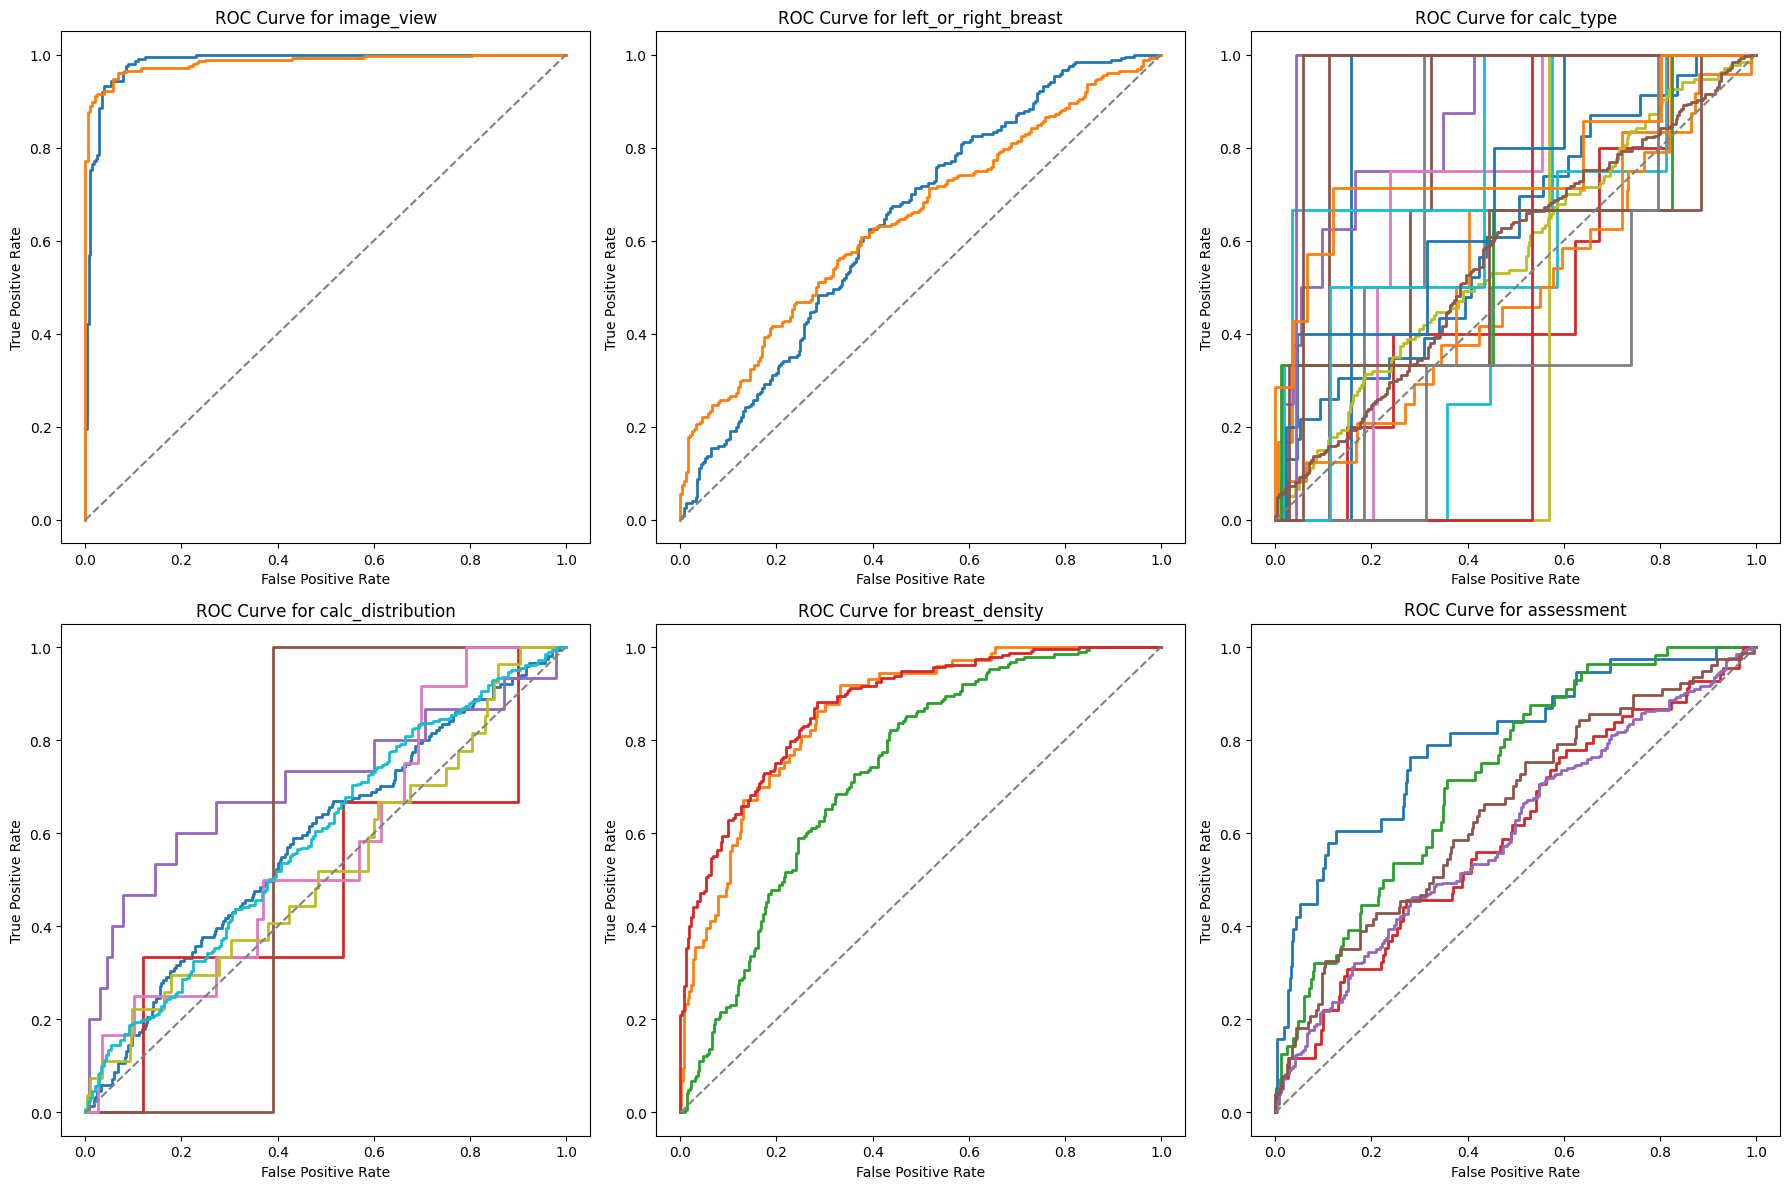

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

for i, col in enumerate(num_classes.keys()):
    y_true_bin = y_true[i]
    y_pred_prob_bin = y_pred_probs[i]
    for class_idx in range(num_classes[col]):
        fpr, tpr, _ = roc_curve(y_true_bin[:, class_idx], y_pred_prob_bin[:, class_idx])
        roc_auc = auc(fpr, tpr)
        ax = axes[i // 3, i % 3]
        ax.plot(fpr, tpr, lw=2, label=f'Class {class_idx} (AUC = {roc_auc:.2f})')

    ax.plot([0, 1], [0, 1], color='gray', linestyle='--')
    ax.set_title(f'ROC Curve for {col}')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')


plt.tight_layout()
plt.show()


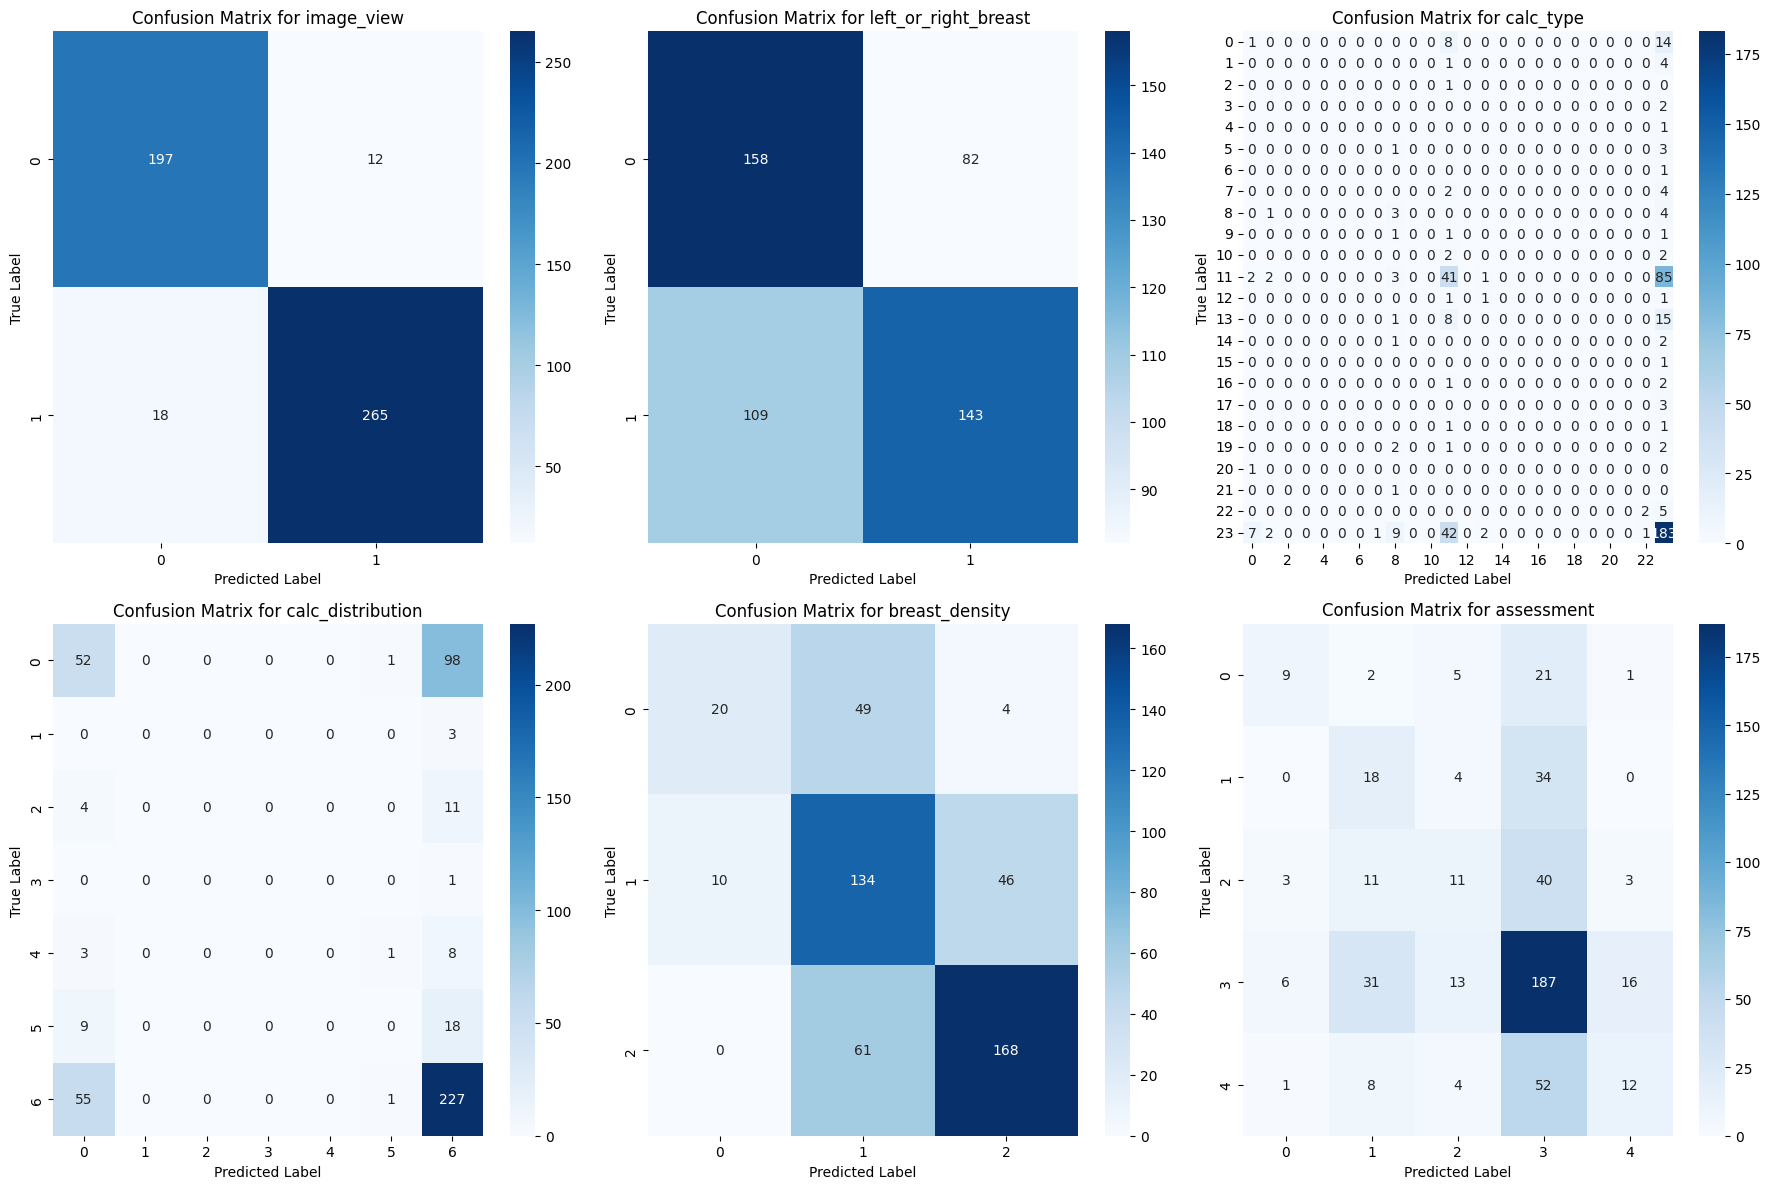

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

for i, col in enumerate(num_classes.keys()):
    cm = confusion_matrix(y_true[i].argmax(axis=1), y_pred_classes[i])
    ax = axes[i // 3, i % 3]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(f'Confusion Matrix for {col}')
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')

plt.tight_layout()
plt.show()

In [ ]:
for i, col in enumerate(num_classes.keys()):
    print(f'Classification Report for {col}')
    print(classification_report(y_true[i].argmax(axis=1), y_pred_classes[i]))

Classification Report for image_view
              precision    recall  f1-score   support

           0       0.92      0.94      0.93       209
           1       0.96      0.94      0.95       283

    accuracy                           0.94       492
   macro avg       0.94      0.94      0.94       492
weighted avg       0.94      0.94      0.94       492

Classification Report for left_or_right_breast
              precision    recall  f1-score   support

           0       0.59      0.66      0.62       240
           1       0.64      0.57      0.60       252

    accuracy                           0.61       492
   macro avg       0.61      0.61      0.61       492
weighted avg       0.61      0.61      0.61       492

Classification Report for calc_type
              precision    recall  f1-score   support

           0       0.09      0.04      0.06        23
           3       0.00      0.00      0.00         5
           5       0.00      0.00      0.00         1
         

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif